In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyodbc
import pandas as pd  # sure takes a long time
import dizzy_util as util
import numpy as np
import umap
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
import cluster_umap
from collections import defaultdict

In [83]:
dataset = util.extractDataset("B00", {"Notes", "AllMed", "Vital", "HF", "DispensedDrug", "Lab"})

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_cohort,BASE TABLE
1,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_Demorgraphics,BASE TABLE
2,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_04_04_Lab,BASE TABLE
3,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_05_04_Rad,BASE TABLE
4,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat,BASE TABLE
5,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_05_BCMA_Dispense...,BASE TABLE
6,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed,BASE TABLE
7,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_08_AllMed,BASE TABLE
8,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_08_Consult,BASE TABLE
9,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_12_ICD,BASE TABLE


dict_keys(['cohort', 'Demorgraphics', 'Rad', 'RxOutpat', 'NonVAMed', 'Consult', 'ICD', 'Note', 'WithRole'])


In [87]:
dizziness_df, label_map = util.retrieveLabels()
label_df = util.convertLabelMap(label_map)
datasubset = util.extractAndStandarizeCohort(dataset, "Dizziness")

,DxErrorER,DxErrorERCoded
0,3,MOD
1,3,MOD
2,2,PMOD
3,1,NoMOD
4,3,MOD
...,...,...
95,3,MOD
96,2,PMOD
97,1,NoMOD
98,1,NoMOD


In [88]:
edstart = util.extractFirstVisitIndexDatetime(datasubset["cohort"])

In [ ]:
filtered_icd_df = util.filterDFByTimes(datasubset["ICD"], util.ICD_PATIENT_ID, "DiagDateTime", edstart)
icd_vec = util.makeICDFeatureVector(filtered_icd_df)
display(icd_vec)

In [44]:
def plot_distributions(feature_vec, key="PatientSSN"):
    i=1
    for c in list(feature_vec.columns):
        plt.figure(i)
        if c == key:
            continue
#         feature_vec[c].value_counts().sort_index().plot(kind="bar", title=c)
        feature_vec[c].plot.hist(title=c)
        i+=1

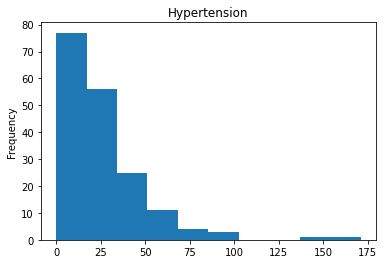

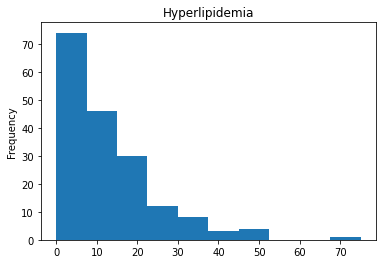

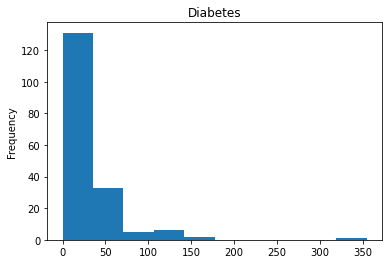

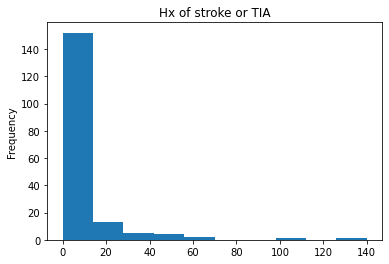

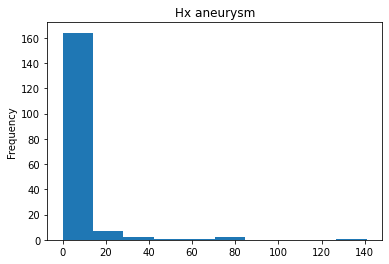

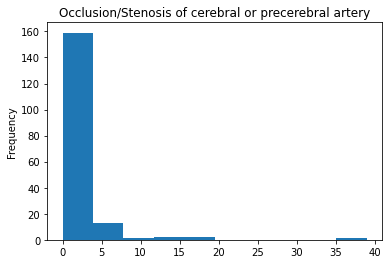

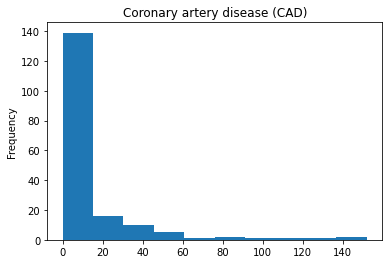

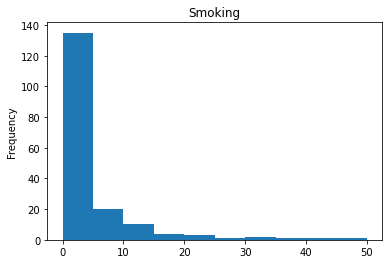

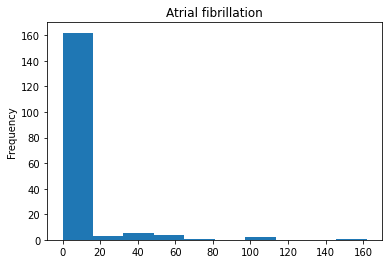

In [47]:
plot_distributions(icd_vec)

In [ ]:
outpat_df = datasubset["RxOutpat"]
filtered_outpat_df = util.filterDFByTimes(outpat_df, util.DRUG_PATIENT_ID, "DispensedDate", edstart)
outpat_vec1 = util.makeRxOutpatTimeWindowVec(filtered_outpat_df, edstart)
display(outpat_vec1)

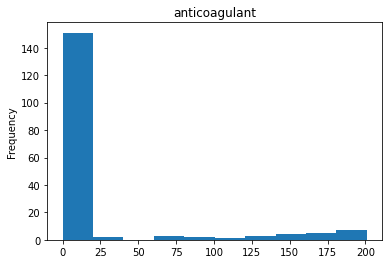

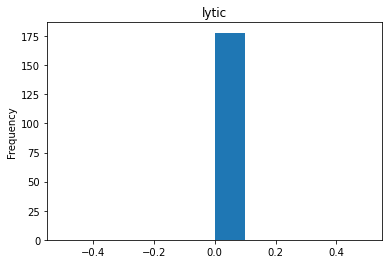

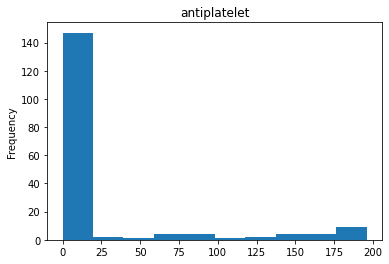

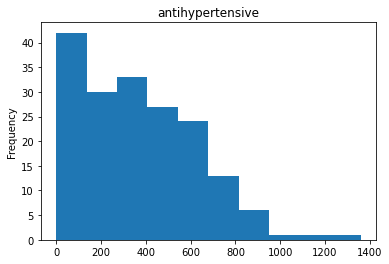

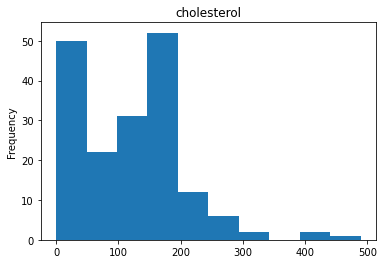

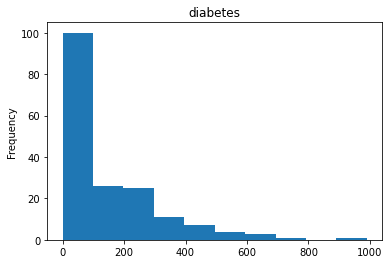

In [46]:
plot_distributions(outpat_vec)

In [ ]:
plot_distributions()

In [66]:
datasubset["cohort"] = datasubset["cohort"].merge(label_df.rename(columns={"PatientSSN":"patientSSN"}))

In [63]:
def extractSubset(ds, subsetNames):
    pkeys = util.getPrimaryKeys(dataset)
    cohort_key = pkeys["cohort"]
    cohort_subset = ds["cohort"][ds["cohort"].Label.isin(subsetNames)]
    ids = pd.DataFrame({cohort_key: cohort_subset[cohort_key].unique()})
    dss = dict()
    for table, df in ds.items():
        dss[table] = ids.merge(df, how="inner", left_on=cohort_key, right_on=pkeys[table])
        if pkeys[table] != cohort_key:
            dss[table] = dss[table].drop([cohort_key], axis=1)
        dss[table][pkeys[table]] = dss[table][pkeys[table]].astype(int)
    return dss

In [69]:
modsubset = extractSubset(datasubset, ["MOD", "PMOD"])
nomodsubset = extractSubset(datasubset, ["NoMOD"])

In [77]:
filtered_icd_df = util.filterDFByTimes(modsubset["ICD"], util.ICD_PATIENT_ID, "DiagDateTime", edstart)
icd_vec2 = util.makeICDFeatureVector(filtered_icd_df)

filtered_icd_df = util.filterDFByTimes(nomodsubset["ICD"], util.ICD_PATIENT_ID, "DiagDateTime", edstart)
icd_vec3 = util.makeICDFeatureVector(filtered_icd_df)

In [75]:
outpat_df = modsubset["RxOutpat"]
filtered_outpat_df = util.filterDFByTimes(outpat_df, util.DRUG_PATIENT_ID, "DispensedDate", edstart)
outpat_vec2 = util.makeRxOutpatTimeWindowVec(filtered_outpat_df, edstart)

outpat_df = nomodsubset["RxOutpat"]
filtered_outpat_df = util.filterDFByTimes(outpat_df, util.DRUG_PATIENT_ID, "DispensedDate", edstart)
outpat_vec3 = util.makeRxOutpatTimeWindowVec(filtered_outpat_df, edstart)

In [73]:
def plot_3distributions(feature_vec1, feature_vec2, feature_vec3, key="PatientSSN"):
    i=1
    for c in list(feature_vec1.columns):
        plt.figure(i)
        if c == key:
            continue
#         feature_vec[c].value_counts().sort_index().plot(kind="bar", title=c)
        plt.subplot(1,3,1)
        feature_vec1[c].plot.hist(title=c)
        plt.subplot(1,3,2)
        feature_vec2[c].plot.hist(title=c)
        plt.subplot(1,3,3)
        feature_vec3[c].plot.hist(title=c)
        i+= 1

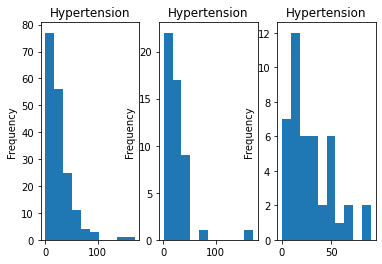

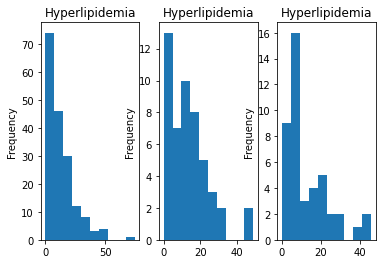

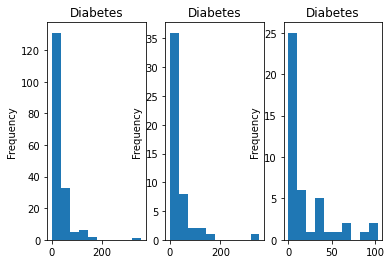

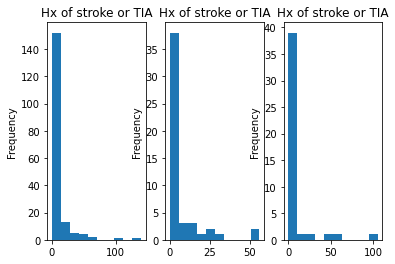

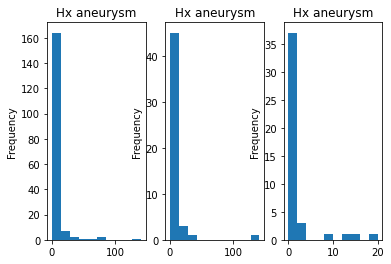

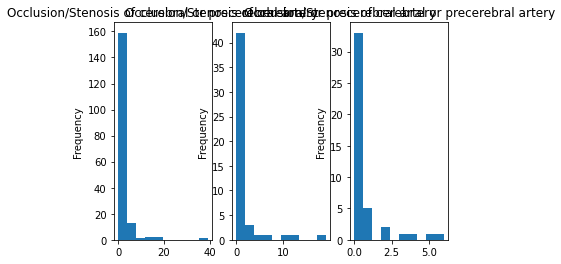

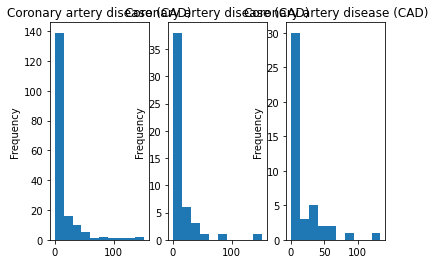

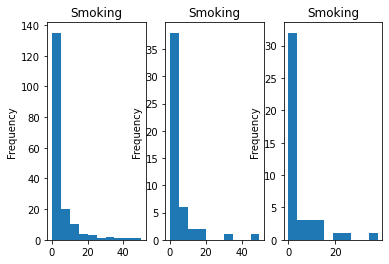

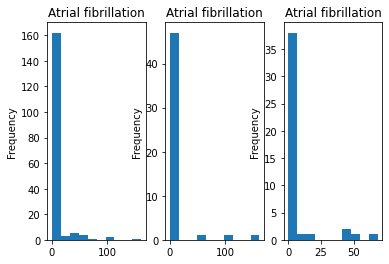

In [78]:
plot_3distributions(icd_vec, icd_vec2, icd_vec3)

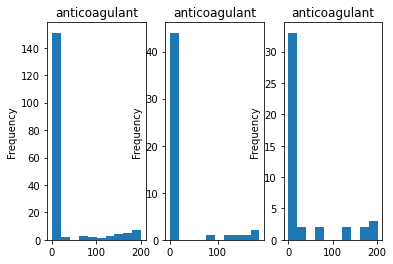

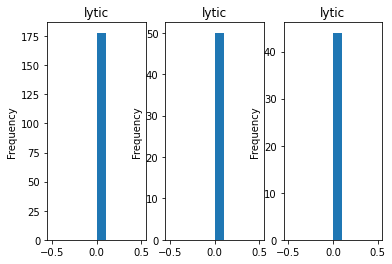

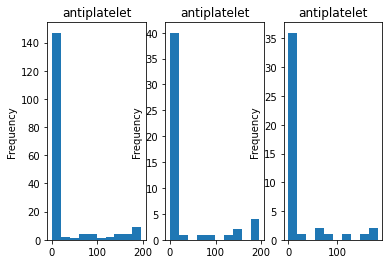

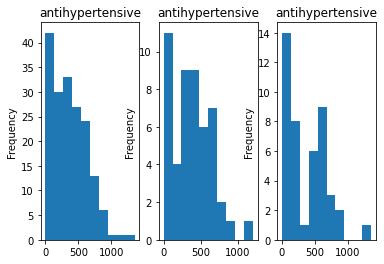

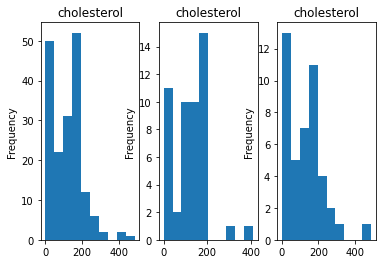

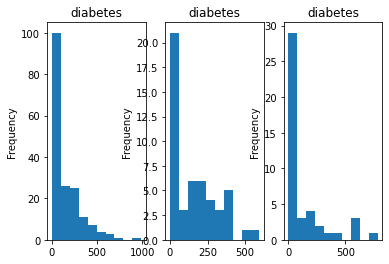

In [76]:
plot_3distributions(outpat_vec1, outpat_vec2, outpat_vec3)

In [89]:
demo_df = datasubset["Demorgraphics"]
age_feature = util.makeAgeFeature(demo_df)
cohort_df = datasubset["cohort"]
index_feature = util.makeIndexFeature(cohort_df)

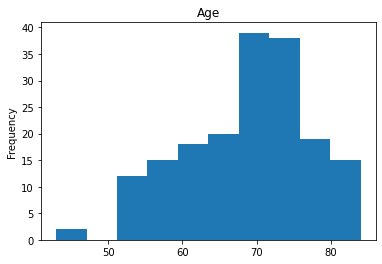

In [90]:
plot_distributions(age_feature.vec)

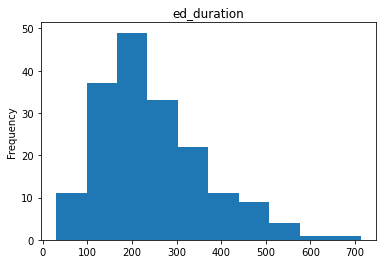

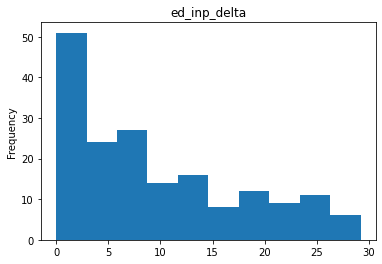

In [91]:
plot_distributions(index_feature.vec)